# Imports

In [50]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from skimage import io, color, graph, segmentation, filters, measure, morphology, draw
from skimage.measure import regionprops
from skimage.transform import resize
import networkx as nx
from multiprocessing import Pool
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Parameters

In [70]:
NUMBER_OF_THREADS = 4

DATASET = Path("water-bodies-dataset")

CROP_RATIO = 1

SEGMENTATION_COMPACTNESS = 30
NUMBER_OF_SEGMENTS = 750
WEIGHT_THRESHOLD = 30

RANDOM_STATE = 0

TEMPORARY_SUBSET_OF_DATASET = 50

CLASSES = 3

# Initialization

In [52]:
np.random.seed(RANDOM_STATE)

# Loading Dataset

In [53]:
images = sorted(DATASET.glob("Images/*.*"))
masks = sorted(DATASET.glob("Masks/*.*"))

In [54]:
for i, image in enumerate(images):
    image = io.imread(image)
    height, width, _ = image.shape
    if CROP_RATIO != 1:
        image = image[:height // CROP_RATIO, :width // CROP_RATIO, :]
    images[i] = image

# Visualization

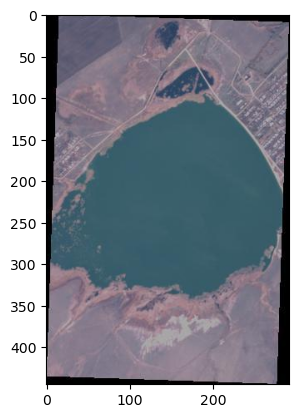

In [89]:
import matplotlib.pyplot as plt

sample_image = images[54]

plt.imshow(sample_image)

plt.show()

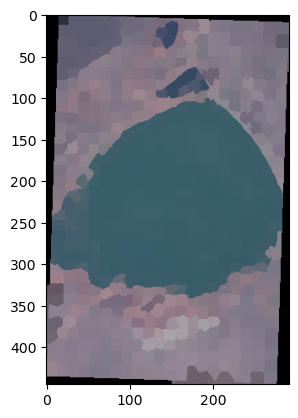

In [90]:
labels = segmentation.slic(sample_image, compactness = SEGMENTATION_COMPACTNESS, n_segments = NUMBER_OF_SEGMENTS)
labels = labels + 1

regions = regionprops(labels)

label_rgb = color.label2rgb(labels, sample_image, kind = "avg")

plt.imshow(label_rgb)

plt.show()

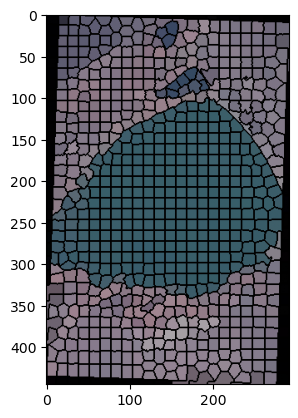

In [91]:
label_rgb = segmentation.mark_boundaries(label_rgb, labels, (0, 0, 0))
plt.imshow(label_rgb)
plt.show()

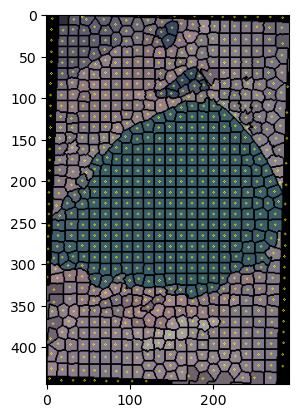

In [92]:
rag = graph.rag_mean_color(sample_image, labels)

for region in regions:
    rag.nodes[region["label"]]["centroid"] = region["centroid"]

def display_edges (image, g, threshold):
    image = image.copy()
    
    for edge in g.edges():
        n1, n2 = edge
 
        r1, c1 = map(int, rag.nodes[n1]["centroid"])
        r2, c2 = map(int, rag.nodes[n2]["centroid"])
 
        line  = draw.line(r1, c1, r2, c2)
        circle = draw.circle_perimeter(r1,c1,1)
 
        if g[n1][n2]["weight"] >= threshold:
            image[line] = 0,1,0
        
        image[circle] = 1,1,0
 
    return image

edges_drawn_all = display_edges(label_rgb, rag, np.inf)
plt.imshow(edges_drawn_all)
plt.show()

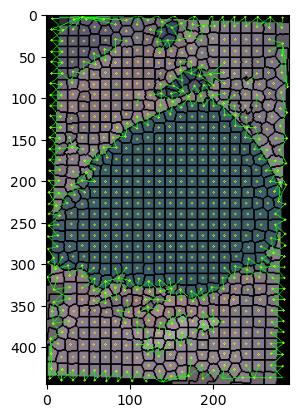

In [93]:
edges_drawn_partial = display_edges(label_rgb, rag, WEIGHT_THRESHOLD)
plt.imshow(edges_drawn_partial)
plt.show()

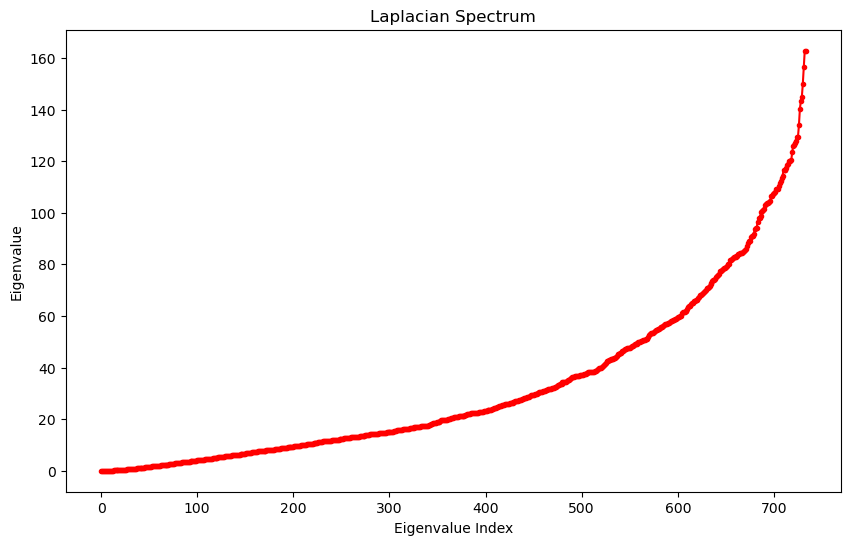

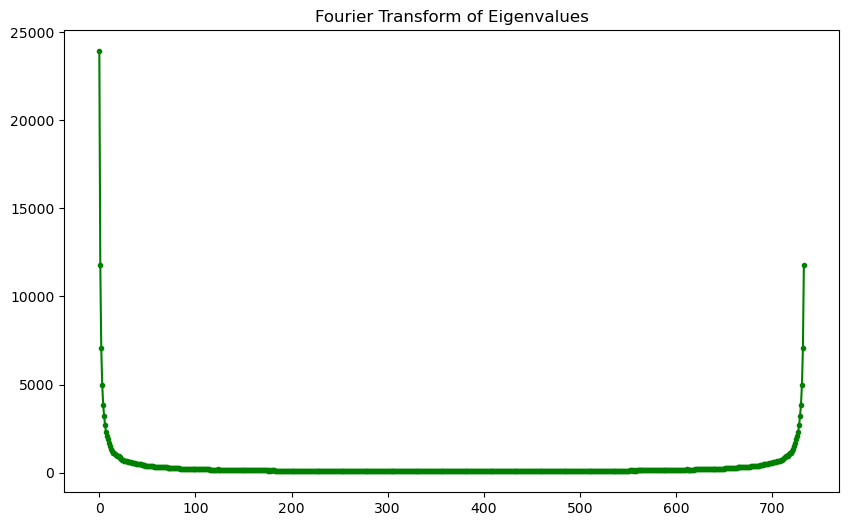

In [94]:
def filter_edges (g, threshold):
    G = nx.Graph()
    
    for edge in g.edges(): 
        n1, n2 = edge
        
        if g[n1][n2]["weight"] < threshold:
            G.add_edge(*edge, weight = g[n1][n2]["weight"])

    return G
 
G = filter_edges(rag, WEIGHT_THRESHOLD)

laplacian_spectrum = sorted(nx.laplacian_spectrum(G))

plt.figure(figsize = (10, 6))
plt.plot(laplacian_spectrum, markersize = 3, color = "red", marker = "o")
plt.title("Laplacian Spectrum")
plt.xlabel("Eigenvalue Index")
plt.ylabel("Eigenvalue")
plt.show()

fourier_transform = np.abs(np.fft.fft(laplacian_spectrum))

plt.figure(figsize = (10, 6))
plt.plot(fourier_transform, markersize = 3, color = "green", marker = "o")
plt.title("Fourier Transform of Eigenvalues")
plt.show()


# Analysis (Multithreaded)

In [64]:
def filter_edges (g, threshold):
    G = nx.Graph()
    
    for edge in g.edges(): 
        n1, n2 = edge
        
        if g[n1][n2]["weight"] < threshold:
            G.add_edge(*edge, weight=g[n1][n2]["weight"])
        
    return G

def process (image, compactness = SEGMENTATION_COMPACTNESS, n_segments = NUMBER_OF_SEGMENTS, threshold = WEIGHT_THRESHOLD):
    labels = segmentation.slic(image, compactness=compactness, n_segments=n_segments)
    labels = labels + 1
    regions = regionprops(labels)

    label_rgb = color.label2rgb(labels, image, kind = "avg")
    label_rgb = segmentation.mark_boundaries(label_rgb, labels, (0, 0, 0))
    
    rag = graph.rag_mean_color(image, labels)

    for region in regions:
        rag.nodes[region["label"]]["centroid"] = region["centroid"]

    G = filter_edges(rag, threshold)

    if not G.nodes():
        return []

    laplacian_spectrum = nx.laplacian_spectrum(G)

    return laplacian_spectrum

X = []

with Pool(NUMBER_OF_THREADS) as p:
    X = list(
        tqdm(
            p.imap(
                process,
                images[:TEMPORARY_SUBSET_OF_DATASET]
            ),
            total = len(images[:TEMPORARY_SUBSET_OF_DATASET])
        )
    )

100%|███████████████████████████████████████████| 50/50 [01:11<00:00,  1.43s/it]


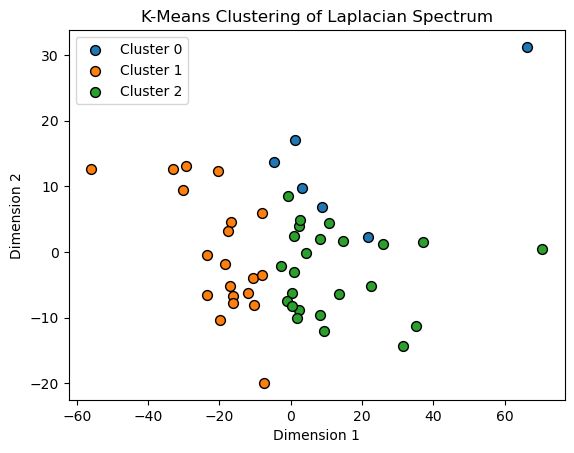

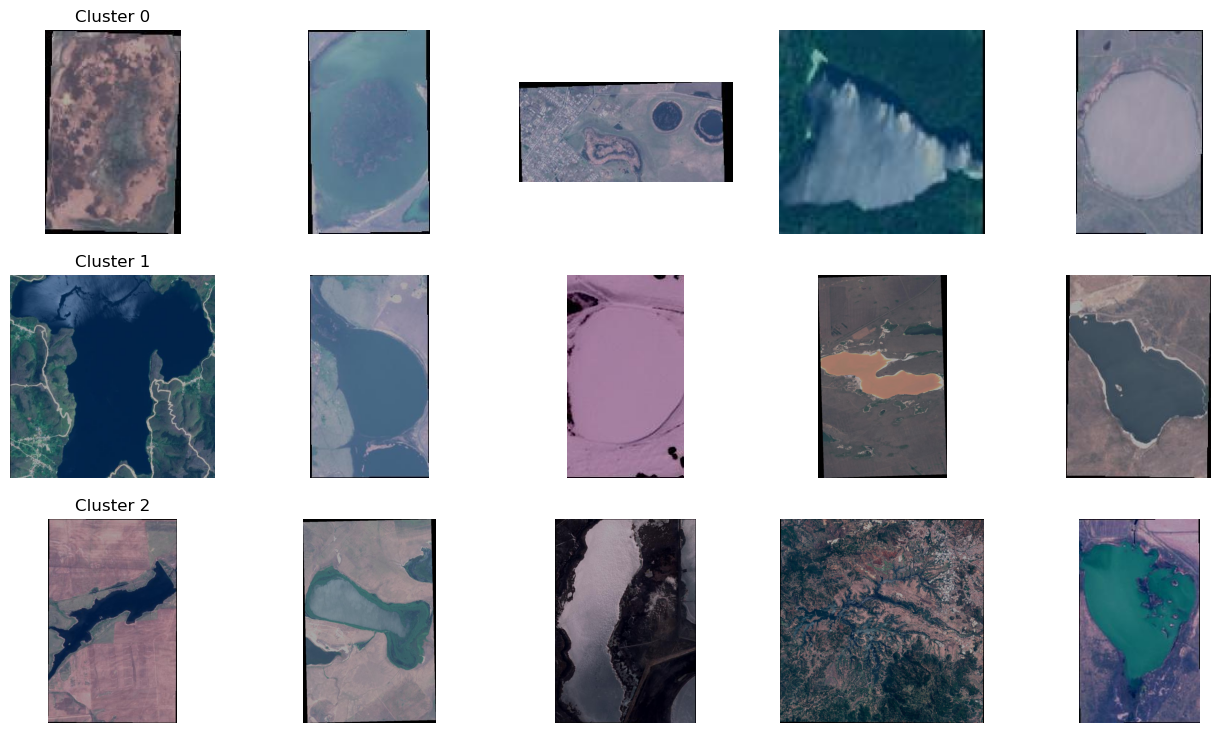

In [74]:
max_length = max(len(x) for x in X)

padded_X = [np.pad(x, (0, max_length - len(x)), "constant") for x in X]

X = np.array(padded_X)

scaler = StandardScaler()
X = scaler.fit_transform(X)

num_clusters = CLASSES

kmeans = KMeans(n_clusters = num_clusters, random_state = RANDOM_STATE)
labels = kmeans.fit_predict(X)

data_with_labels = np.column_stack((X, labels))

pca = PCA(n_components = 2)
pca_result = pca.fit_transform(X)

unique_labels = list(set(labels))

for label in unique_labels:
    indices = [i for i, x in enumerate(labels) if x == label]
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=f'Cluster {label}', s = 50, edgecolor = "k")

plt.title("K-Means Clustering of Laplacian Spectrum")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()

fig = plt.figure(figsize = (16, 9))
gs = gridspec.GridSpec(num_clusters, 5, width_ratios = [1] * 5)

for cluster_id in range(num_clusters):
    cluster_indices = np.where(data_with_labels[:, -1] == cluster_id)[0]
    random_indices = np.random.choice(cluster_indices, 5, replace=False)

    for i, img_index in enumerate(random_indices):
        ax = plt.subplot(gs[cluster_id * 5 + i])
        img =  (images[img_index])
        ax.imshow(img, cmap="gray")
        ax.axis("off")
        if i == 0:
            ax.set_title(f'Cluster {cluster_id}')

plt.show()
